# Differential expression analysis of TMT labeled phosphoproteome data using Limma's moderated t-test
## searched with MaxQuant v.1.6.10.43 with unitprot reviewed mouse DB, without isoforms, with PIF cutoff (0.75) and iBAQ calculation enabled

### Author: Konstantin Kahnert
### Date: 2020_09_15

After the initial data processing and anlysis, we continue with the differential expression protein analysis.  
In this script we will:

- use the moderated t-test of the limma package to determine significantly differentially expressed proteins

## Load required libraries

In [1]:
library(limma)
library(qvalue)
library(stringr)

## Load function from Kammers et al. 2015 ("Detecting significant changes in protein abundance", doi: 10.1016/j.euprot.2015.02.002)

In [2]:
source("http://www.biostat.jhsph.edu/~kkammers/software/eupa/source.functions.r")

## Load data

In [7]:
path_input <- file.path("E:/Data/Heart_failure_mice_CS/Sinus_node/Phosphoproteome/Analysis/",
                        "03_volcano_plot_analysis/phosphosites(STY)_proteome_ratio_norm.csv")

data_raw <- read.csv(path_input)
head(data_raw)

,X,Sham.1,Sham.2,Sham.3,Sham.4,Sham.5,TAC.1,TAC.2,TAC.3,TAC.4,...,Leading.proteins,Protein,Protein.names,Gene.names,Sequence.window,Modification.window,Phospho..STY..Probabilities,id,Unique.identifier,Number.of.Phospho..STY.
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>
1,0,1.2758870,1.5161991,1.11567307,1.36297417,1.12616396,1.83795445,1.26019757,1.77124398,1.4231714,...,P0DPB4,P0DPB4,,Schip1,DADDSKTETSLDTPLSPMSKQSSSYSDRDTT,X;X;X;X;X;X;X;X;X;X;X;X;X;X;X;Phospho (STY);X;Oxidation (M);X;X;X;X;X;X;X;X;X;X;X;X;X,TETSLDT(0.001)PLS(0.995)PMS(0.005)K,1,UID2,1
2,1,0.5615010,-0.1484661,0.26981735,-0.01501656,-0.08783102,-0.28256371,-0.19146969,0.20337532,-0.2246704,...,A2A5R2,A2A5R2,Brefeldin A-inhibited guanine nucleotide-exchange protein 2,Arfgef2,GKVSLENGEAPRERGSPVSGRAEPSRGTDSG,X;X;X;Phospho (STY);X;X;X;X;X;X;X;X;X;X;X;Phospho (STY);X;X;X;X;X;X;X;X;X;X;X;X;X;X;X,GS(1)PVSGR,3,UID4,1
3,2,0.2646632,0.6021538,0.32192802,0.17565060,0.08780527,-0.26602795,-0.18258335,-0.11225273,0.1168785,...,A2A5R2,A2A5R2,Brefeldin A-inhibited guanine nucleotide-exchange protein 2,Arfgef2,MQSKPQSPVIQATAGSPKFSRLKQSQAQSKP,X;X;X;X;X;X;X;X;X;X;X;X;X;X;X;Phospho (STY);X;X;X;X;X;X;X;X;X;X;X;X;X;X;X,PQSPVIQAT(0.025)AGS(0.975)PK,6,UID7,1
4,3,-0.2172036,-0.3231421,-0.16507435,0.20213127,-0.52896166,0.04375790,-0.28870823,-0.14638474,-0.4428320,...,A2A5R2,A2A5R2,Brefeldin A-inhibited guanine nucleotide-exchange protein 2,Arfgef2,NSQTNGIADDRQSLSSADNLEPDVQGHQVAA,X;X;X;X;X;X;X;X;X;X;X;X;X;X;X;Phospho (STY);X;X;X;X;X;X;X;X;X;X;X;X;X;X;X,QS(0.002)LS(0.117)S(0.881)ADNLEPDVQGHQVAAR,7,UID8,1
5,4,0.1961770,0.3714314,0.06090355,0.06591034,0.16198969,-0.01508953,-0.01365902,-0.03784039,0.2103109,...,A2A5R2,A2A5R2,Brefeldin A-inhibited guanine nucleotide-exchange protein 2,Arfgef2,ELPNGDHAQSGLGKVSLENGEAPRERGSPVS,X;X;X;X;X;X;X;X;X;X;X;X;X;X;X;Phospho (STY);X;X;X;X;X;X;X;X;X;X;X;Phospho (STY);X;X;X,VS(1)LENGEAPR,8,UID9,1
6,5,-1.1972442,-1.3334780,-1.44691372,-1.50280857,-1.13325167,-1.75674315,-1.99431392,-2.00980922,-1.6390268,...,A2A690,A2A690,Protein TANC2,Tanc2,GSHQVFDFRSNSSVGSPTRQGYQSTSPALSP,X;X;X;X;X;X;X;X;X;X;X;X;X;X;X;Phospho (STY);X;X;X;X;X;X;X;X;X;X;X;X;X;X;X,SNSSVGS(0.999)PT(0.001)R,9,UID10,1


## Define treatment and control groups for two group comparison, assuming 5 cases and 5 controls


In [8]:
ct <- c("Sham.1", "Sham.2", "Sham.3", "Sham.4", "Sham.5")
tr <- c("TAC.1", "TAC.2", "TAC.3", "TAC.4", "TAC.5")

## Define design according to syntax of limma package

In [9]:
design <- model.matrix(~factor(c(1,1,1,1,1,2,2,2,2,2))) # first five samples control, next five case

colnames(design) <- c("Intercept", "Diff")
design

,Intercept,Diff
1,1,0
2,1,0
3,1,0
4,1,0
5,1,0
6,1,1
7,1,1
8,1,1
9,1,1
10,1,1


## Fit linear model and determine differentially expressed proteins

In [10]:
res.eb <- eb.fit(data_raw[, c(ct, tr)], design)
head(res.eb)

,logFC,t.ord,t.mod,p.ord,p.mod,q.ord,q.mod,df.r,df.0,s2.0,s2,s2.post
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
3219,1.1237802,16.48609,14.13049,1.848888e-07,2.481667e-08,0.0001524347,3.884254e-05,8,2.855463,0.02756714,0.011616291,0.015812064
2721,0.8363079,26.64550,13.88739,4.233577e-09,2.968921e-08,0.0000113339,3.884254e-05,8,2.855463,0.02756714,0.002462775,0.009066324
279,1.0087722,16.05056,13.23262,2.277571e-07,4.881636e-08,0.0001524347,4.257778e-05,8,2.855463,0.02756714,0.009875197,0.014528954
2153,1.2284616,11.96051,11.88993,2.198397e-06,1.455094e-07,0.0004527252,9.518533e-05,8,2.855463,0.02756714,0.026373269,0.026687309
1142,-0.9113841,-13.70572,-11.61284,7.740601e-07,1.847475e-07,0.0002302523,9.668242e-05,8,2.855463,0.02756714,0.011054501,0.015398049
3101,0.7883774,15.51185,11.37430,2.970022e-07,2.278087e-07,0.0001590236,9.934774e-05,8,2.855463,0.02756714,0.006457752,0.012010447


## Plot volcano plots for ordinary and moderated p-values

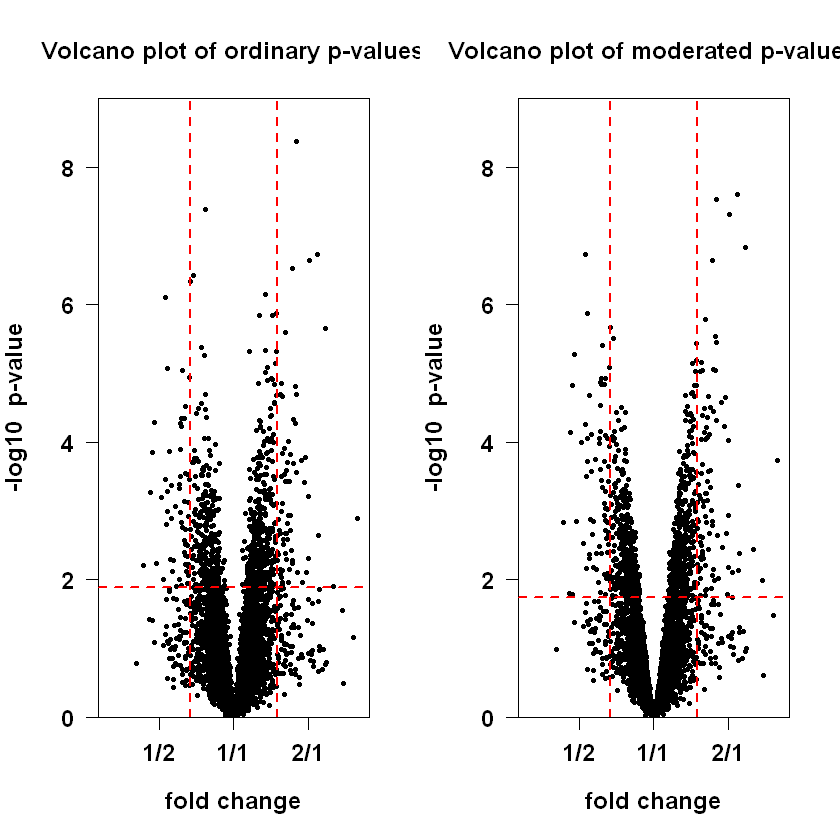

In [11]:
rx <- c(-1, 1)*max(abs(res.eb$logFC))*1.1
ry <- c(0, ceiling(max(-log10(res.eb$p.ord), -log10(res.eb$p.mod))))

par(mfrow=c(1,2), font.lab=2, cex.lab=1.2, font.axis=2, cex.axis=1.2)
par(las=1, xaxs="i", yaxs="i")

# ordinary p-values
plot(res.eb$logFC, -log10(res.eb$p.ord), pch=20, bg="black", cex=0.9, 
     xlim=rx, ylim=ry, xaxt="n",
     xlab="fold change", ylab="-log10  p-value")
abline(h=1.88515, col="red", lty="dashed",lwd=2)
abline(v=c(-0.58496, 0.58496), col="red", lty="dashed",lwd=2)
axis(1, seq(-2,2,1), paste(c("1/4","1/2","1/1","2/1","4/1")))
title("Volcano plot of ordinary p-values")

# moderated p-values
plot(res.eb$logFC, -log10(res.eb$p.mod), pch=20, bg="black", cex=0.9,
     xlim=rx, ylim=ry, xaxt="n",
     xlab="fold change", ylab="-log10  p-value")
abline(h=1.7504, col="red", lty="dashed", lwd=2)
abline(v=c(-0.58496, 0.58496), col="red", lty="dashed",lwd=2)
axis(1, seq(-2,2,1), paste(c("1/4","1/2","1/1","2/1","4/1")))
title("Volcano plot of moderated p-values")


## Sort dataframes by index


In [12]:
res.eb$index <- as.numeric(row.names(res.eb))
res.eb <- res.eb[order(res.eb$index), ]

data_raw$index <- as.numeric(row.names(data_raw))
data_raw <- data_raw[order(data_raw$index), ]

## Combine dataframes

In [13]:
df_combined <- merge(res.eb, data_raw)

head(df_combined)

,index,logFC,t.ord,t.mod,p.ord,p.mod,q.ord,q.mod,df.r,df.0,...,Leading.proteins,Protein,Protein.names,Gene.names,Sequence.window,Modification.window,Phospho..STY..Probabilities,id,Unique.identifier,Number.of.Phospho..STY.
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,...,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>
1,1,0.35840933,2.4536543,2.6262256,0.0397097738,0.0237975073,0.07486536,0.05219512,8,2.855463,...,P0DPB4,P0DPB4,,Schip1,DADDSKTETSLDTPLSPMSKQSSSYSDRDTT,X;X;X;X;X;X;X;X;X;X;X;X;X;X;X;Phospho (STY);X;Oxidation (M);X;X;X;X;X;X;X;X;X;X;X;X;X,TETSLDT(0.001)PLS(0.995)PMS(0.005)K,1,UID2,1
2,2,-0.19408896,-1.1815819,-1.2858060,0.2713022147,0.2252614846,0.22775646,0.19752725,8,2.855463,...,A2A5R2,A2A5R2,Brefeldin A-inhibited guanine nucleotide-exchange protein 2,Arfgef2,GKVSLENGEAPRERGSPVSGRAEPSRGTDSG,X;X;X;Phospho (STY);X;X;X;X;X;X;X;X;X;X;X;Phospho (STY);X;X;X;X;X;X;X;X;X;X;X;X;X;X;X,GS(1)PVSGR,3,UID4,1
3,3,-0.43222677,-3.8421477,-3.9088732,0.0049321397,0.0025001036,0.02433047,0.01507326,8,2.855463,...,A2A5R2,A2A5R2,Brefeldin A-inhibited guanine nucleotide-exchange protein 2,Arfgef2,MQSKPQSPVIQATAGSPKFSRLKQSQAQSKP,X;X;X;X;X;X;X;X;X;X;X;X;X;X;X;Phospho (STY);X;X;X;X;X;X;X;X;X;X;X;X;X;X;X,PQSPVIQAT(0.025)AGS(0.975)PK,6,UID7,1
4,4,0.09177683,0.5336853,0.5840263,0.6080642201,0.5711390153,0.35537371,0.33392388,8,2.855463,...,A2A5R2,A2A5R2,Brefeldin A-inhibited guanine nucleotide-exchange protein 2,Arfgef2,NSQTNGIADDRQSLSSADNLEPDVQGHQVAA,X;X;X;X;X;X;X;X;X;X;X;X;X;X;X;Phospho (STY);X;X;X;X;X;X;X;X;X;X;X;X;X;X;X,QS(0.002)LS(0.117)S(0.881)ADNLEPDVQGHQVAAR,7,UID8,1
5,5,-0.08194429,-0.9104564,-0.8700578,0.3891897809,0.4030980300,0.27710570,0.27431732,8,2.855463,...,A2A5R2,A2A5R2,Brefeldin A-inhibited guanine nucleotide-exchange protein 2,Arfgef2,ELPNGDHAQSGLGKVSLENGEAPRERGSPVS,X;X;X;X;X;X;X;X;X;X;X;X;X;X;X;Phospho (STY);X;X;X;X;X;X;X;X;X;X;X;Phospho (STY);X;X;X,VS(1)LENGEAPR,8,UID9,1
6,6,-0.51339913,-5.0957354,-5.0388548,0.0009347616,0.0003943557,0.01012876,0.00579705,8,2.855463,...,A2A690,A2A690,Protein TANC2,Tanc2,GSHQVFDFRSNSSVGSPTRQGYQSTSPALSP,X;X;X;X;X;X;X;X;X;X;X;X;X;X;X;Phospho (STY);X;X;X;X;X;X;X;X;X;X;X;X;X;X;X,SNSSVGS(0.999)PT(0.001)R,9,UID10,1


## Save combined dataframe as csv file

In [15]:
path_output <- paste(str_replace(path_input, ".csv", ""), "_empBayes_pvals.csv")
write.csv(df_combined, file=path_output, row.names=FALSE, col.names=TRUE)

Warning message in write.csv(df_combined, file = path_output, row.names = FALSE, :
"attempt to set 'col.names' ignored"
